# Three-arm Antenna Position Calibration

Author: Tim Molteno. tim@elec.ac.nz.

The antennas are laid out on three arms which are placed approximately 120 degrees apart.  This notebook will use measurements to infer the actual layout of the antennas.

Arm 1 will point geographically north (NOT magnetic). This arm forms the y-axis and will be used as a reference. We will assume that the x positions along this arm are approximately zero.

The other reference point is the center of the array. This is assumed to be the point [0,0]. Make sure that a marker is present at this reference point at the same height as the level of the antennas (otherwise the distances will be wrong).

In [1]:
import numpy as np
from scipy.optimize import minimize 

In [2]:
x0 = [0,0]

In [3]:
# pip install pandas
# pip install odfpy

import pandas as pd

#pd.read_excel('three_arm_measurements.ods', engine='odf')
cols = [f"A {i}" for i in range(24)]
data = pd.read_excel('three_arm_measurements.ods', "Sheet1", usecols=cols)
radius = data.loc[0]
radius

A 0      210.0
A 1      410.0
A 2      384.0
A 3      638.0
A 4      212.0
A 5      753.0
A 6     1261.0
A 7     1436.0
A 8     1707.0
A 9     1864.0
A 10    2199.0
A 11    2386.0
A 12     937.0
A 13    1084.0
A 14    1621.0
A 15    1924.0
A 16    2091.0
A 17    2408.0
A 18     914.0
A 19    1254.0
A 20    1575.0
A 21    1696.0
A 22    1856.0
A 23    2076.0
Name: 0, dtype: float64

## Finding the antennas

This is done by measuring the distance from each antenna to x0 as well as each other antenna. The distance $m_0$ are the measurements to $x_0$. The array m_ij are the distances between antennas.

In [4]:
n_ant = 24
m_0 = np.zeros(24)
m_ij = np.zeros((24,24))

radius = data.loc[0]

for i in range(24):
    m_ij[i,:] = data.loc[i+1]

The following are the measured distances from [x1, x0, x2] from the reference points in millimeters. Note that their order must be the same as the order of the variable called 'reference_points'. In this case, they are x1,x0,x2.

In [5]:
for i in range(n_ant):
    for j in range(n_ant):
        if not np.isnan(m_ij[i,j]):
            m_ij[j,i] = m_ij[i,j]

## Plot the Initial Guess Points

Initial Guesses are from JSON queried from the telescope API. These are converted to millimeters.

In [6]:
import requests
import json

def get_data(path):
    server = "https://tart.elec.ac.nz/rhodes"

    r = requests.get('{}/{}'.format(server, path))
    return json.loads(r.text)

def get_pos():
    return np.array(get_data('api/v1/imaging/antenna_positions'))

if False:
    with open('original_rhodes_positions.json', "r") as f:
        data = f.read()
    cal_json = json.loads(data)
    current_pos = cal_json['antenna_positions'] # get_pos()
    current_pos = np.array(current_pos)

if False:
    current_pos = get_pos()
    json_result = {}
    json_result["antenna_positions"] = current_pos.tolist()
    print(json.dumps(json_result, indent=4, separators=(',', ': ')))

current_pos = np.array([[ 0.        ,  0.21036822,  0.        ],
       [ 0.        ,  0.40894464,  0.        ],
       [ 0.33652171, -0.1942909 ,  0.        ],
       [ 0.55195215, -0.31866972,  0.        ],
       [-0.18186395, -0.1049992 ,  0.        ],
       [-0.65058666, -0.37561638,  0.        ],
       [ 0.        ,  1.26747133,  0.        ],
       [ 0.        ,  1.44403899,  0.        ],
       [ 0.        ,  1.71019648,  0.        ],
       [ 0.        ,  1.86051529,  0.        ],
       [ 0.        ,  2.20143587,  0.        ],
       [ 0.        ,  2.38582938,  0.        ],
       [ 0.81594596, -0.47108662,  0.        ],
       [ 0.94307482, -0.5444845 ,  0.        ],
       [ 1.40247705, -0.8097205 ,  0.        ],
       [ 1.66872406, -0.96343829,  0.        ],
       [ 1.80943056, -1.04467522,  0.        ],
       [ 2.08400692, -1.20320196,  0.        ],
       [-0.78741312, -0.45461318,  0.        ],
       [-1.08399029, -0.62584208,  0.        ],
       [-1.36391741, -0.78745808,  0.        ],
       [-1.46598234, -0.8463853 ,  0.        ],
       [-1.60875644, -0.92881597,  0.        ],
       [-1.80004538, -1.03925669,  0.        ]])

## Parameter Mapping

The parameters will be 24 radius measurements and three angle measurements. The first arm is assumed to be at angle zero. The first task is to get these parameters from the initial position estimate.

In [7]:
arm_angle_indices = np.zeros(24, dtype=int)
arm_0 = [0, 1, 6, 7, 8, 9, 10, 11]
arm_1 = [2, 3, 12, 13, 14, 15, 16, 17]
arm_2 = [4, 5, 18, 19, 20, 21, 22, 23]

arm_angle_indices[arm_0] = 0
arm_angle_indices[arm_1] = 1
arm_angle_indices[arm_2] = 2

arm_angle_indices

def split_param(x):
    arm_angles = x[0:3]
    radii = x[3:n_ant+3]
    
    return arm_angles, radii

def p(x, i): # Coordinates for the ith antenna from parameters x
    arm_angles, radii = split_param(x)
    
    r = radii[i]
    ai = arm_angle_indices[i]
    
    theta = arm_angles[ai]
    
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return [x,y]

In [8]:
def plot_ant(ax, p):
    for i in range(0,p.shape[0]):
        ax.text(p[i,0], p[i,1],f"{i}")


In [9]:
n_param = n_ant + 3

initial_guess = np.zeros(n_param)


for i in range(n_ant):
    x,y = current_pos[i][0:2]*1000
    
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x)
    
    ai = arm_angle_indices[i]
    initial_guess[ai] = theta
    initial_guess[3+i] = r
    
    print(x,y, r, theta)
initial_guess

pos_i = current_pos*1000
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,12))

plot_ant(ax, pos_i)

ax.grid(True)
ax.set_title('Initial positions')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
plt.savefig('initial_positions.png')
plt.show()

0.0 210.36822 210.36822 1.5707963267948966
0.0 408.94464000000005 408.94464000000005 1.5707963267948966
336.52171 -194.2909 388.58179978497975 -0.5235987759177734
551.95215 -318.66972 637.339443573439 -0.5235987723612076
-181.86395 -104.9992 209.99840073258295 -2.6179938800055904
-650.5866599999999 -375.61638000000005 751.2327649232693 -2.6179938817752095
0.0 1267.47133 1267.47133 1.5707963267948966
0.0 1444.03899 1444.03899 1.5707963267948966
0.0 1710.19648 1710.19648 1.5707963267948966
0.0 1860.5152899999998 1860.5152899999998 1.5707963267948966
0.0 2201.4358700000003 2201.4358700000003 1.5707963267948966
0.0 2385.82938 2385.82938 1.5707963267948966
815.94596 -471.08662000000004 942.1732394752814 -0.5235987759198389
943.0748199999999 -544.4845 1088.9690017894368 -0.5235987746495742
1402.47705 -809.7204999999999 1619.4410035246583 -0.5235987743417155
1668.72406 -963.43829 1926.876572866308 -0.523598777735768
1809.43056 -1044.67522 2089.3504413439027 -0.5235987752269382
2084.0069200000

ValueError: Image size of 2600788x2341221 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 864x864 with 1 Axes>

## Criteria for Optimality

The function below is minimized when the positions (in variable x) are consistent with the measured distances m[i,j]. The initial value of this function is more than 3 million.

Note that the x input is a 1D vector of with 48 entries as [p0.x, p0.y, p1.x, p1.y]

In [10]:
initial_guess

array([ 1.57079633e+00, -5.23598777e-01, -2.61799388e+00,  2.10368220e+02,
        4.08944640e+02,  3.88581800e+02,  6.37339444e+02,  2.09998401e+02,
        7.51232765e+02,  1.26747133e+03,  1.44403899e+03,  1.71019648e+03,
        1.86051529e+03,  2.20143587e+03,  2.38582938e+03,  9.42173239e+02,
        1.08896900e+03,  1.61944100e+03,  1.92687657e+03,  2.08935044e+03,
        2.40640391e+03,  9.09226355e+02,  1.25168417e+03,  1.57491617e+03,
        1.69277060e+03,  1.85763193e+03,  2.07851337e+03])

In [11]:
def dist(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

center = [0,0]

def radius_model(x):
    ret = []
    
    for i in range(n_ant):
        p_i = p(x,i)
        ret.append(dist(center, p_i))
        
    return np.array(ret)

non_nan_ij = []
non_nan_indices = []
for i in range(n_ant):
    for j in range(n_ant):
        if not np.isnan(m_ij[i,j]):
            non_nan_ij.append(m_ij[i,j])
            non_nan_indices.append([i,j])
non_nan_ij = np.array(non_nan_ij)
non_nan_indices = np.array(non_nan_indices)

def m_ij_model(x):
    ret = []
    for i in range(n_ant):
        p_i = p(x,i)

        for j in range(n_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret.append(dist(p_j, p_i))
                
    return np.array(ret)
    
def radius_residual(x):
    predict = radius_model(x)
    return predict - radius

def m_ij_residual(x):
    predict = m_ij_model(x)
    return predict - non_nan_ij


def f(x):
    ret = 0
    for i in range(n_ant):
        p_i = p(x,i)
        ret += (dist(center, p_i) - m_0[i])**2
        for j in range(n_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret += (dist(p_j, p_i) - m_ij[i,j])**2
    return ret

def f(x):
    # This is the final criterion for optimality. The sum of squared residuals.
    ret = np.sum(radius_residual(x)**2)
    ret += np.sum(m_ij_residual(x)**2)
    #ret += (100*x[0])**2
    return ret

print(f(initial_guess))

662006.2460546995


We can see that the initial value of this optimality condition is about 600,000.

In [12]:
bnd = [[0, 5000]]*n_param

actual_arm_2 = np.radians(-3) # From survey converted to +x axis being zero, and positive angles anticlockwise

for i in range(3):
    bnd[i] = [-2*np.pi,2*np.pi]
    
eps = 1e-6
bnd[2] = [actual_arm_2 - eps, actual_arm_2 + eps]

res = minimize(f, initial_guess, bounds=bnd, tol=1e-10)
res

      fun: 21650.33622993814
 hess_inv: <27x27 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.12926673,  5.69925763, -8.9265086 ,  0.13314992, -0.28230693,
        1.3449597 ,  1.10085151,  0.53369107, -1.38461364, -0.26848568,
        0.54024557,  1.4741246 , -2.09549795, -0.84001819,  0.7574352 ,
        0.52605132,  0.39472487, -0.8840382 , -0.62173715,  0.51587085,
       -0.60063665, -2.78850854,  1.54688495,  0.3998181 ,  0.28485675,
        1.12596635,  0.54206457])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 6664
      nit: 208
     njev: 238
   status: 0
  success: True
        x: array([ 2.08475310e+00, -2.19031431e+00, -5.23607927e-02,  2.09532194e+02,
        4.08025140e+02,  3.83707885e+02,  6.41007982e+02,  2.06357761e+02,
        7.41509696e+02,  1.26221644e+03,  1.43489756e+03,  1.69888961e+03,
        1.86396896e+03,  2.19338720e+03,  2.38939401e+03,  9.40039168e+02,
        1.08094779e+03,  1.61550741e+03,  1.92256361e+03,  2.

In [13]:
arm_angles, radii = split_param(res.jac)
for i in range(3):
    print(f"  Arm {i}:\tJac: {arm_angles[i]:06.2f}")

print("Antennas")
for i in range(24):
    print(f"  Ant {i}:\tJac: {radii[i]:06.2f}")

  Arm 0:	Jac: 006.13
  Arm 1:	Jac: 005.70
  Arm 2:	Jac: -08.93
Antennas
  Ant 0:	Jac: 000.13
  Ant 1:	Jac: -00.28
  Ant 2:	Jac: 001.34
  Ant 3:	Jac: 001.10
  Ant 4:	Jac: 000.53
  Ant 5:	Jac: -01.38
  Ant 6:	Jac: -00.27
  Ant 7:	Jac: 000.54
  Ant 8:	Jac: 001.47
  Ant 9:	Jac: -02.10
  Ant 10:	Jac: -00.84
  Ant 11:	Jac: 000.76
  Ant 12:	Jac: 000.53
  Ant 13:	Jac: 000.39
  Ant 14:	Jac: -00.88
  Ant 15:	Jac: -00.62
  Ant 16:	Jac: 000.52
  Ant 17:	Jac: -00.60
  Ant 18:	Jac: -02.79
  Ant 19:	Jac: 001.55
  Ant 20:	Jac: 000.40
  Ant 21:	Jac: 000.28
  Ant 22:	Jac: 001.13
  Ant 23:	Jac: 000.54


The optimized positions are now known. The final value of the function is 32. Far closer to zero than 3 million!

We can recover the x,y coordinates by reshaping the array

In [14]:
arm_angles, radii = split_param(res.x)
np.degrees(arm_angles)

array([ 119.44755423, -125.49576575,   -3.00005243])

In [15]:
arm_angles, radii = split_param(res.x)

pos = np.array([p(res.x, i) for i in range(n_ant)])

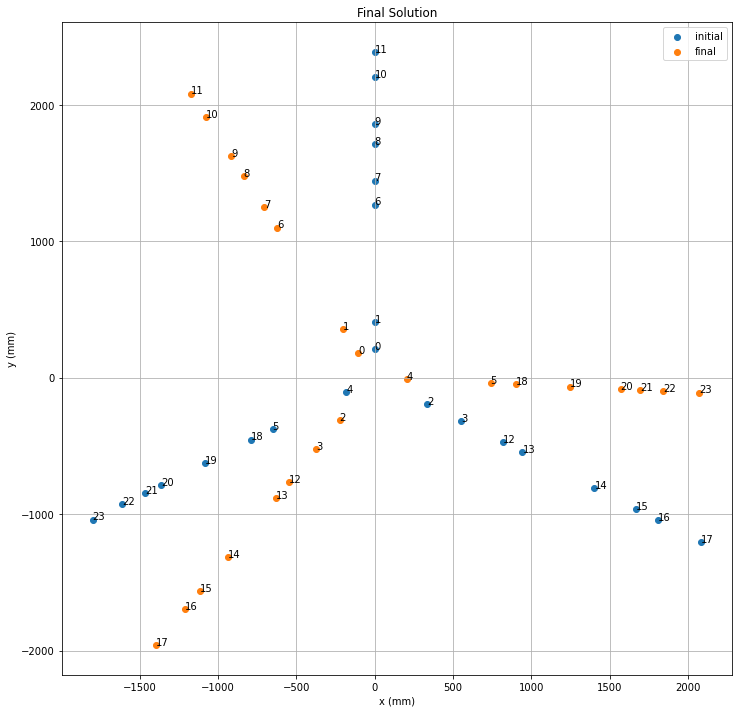

In [16]:
fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(pos_i[:,0], pos_i[:,1], label='initial')
ax.scatter(pos[:,0], pos[:,1], label='final')
plot_ant(ax, pos_i)
plot_ant(ax, pos)

ax.grid(True)
ax.set_title('Final Solution')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.legend()
plt.savefig('final_positions.png')
plt.show()

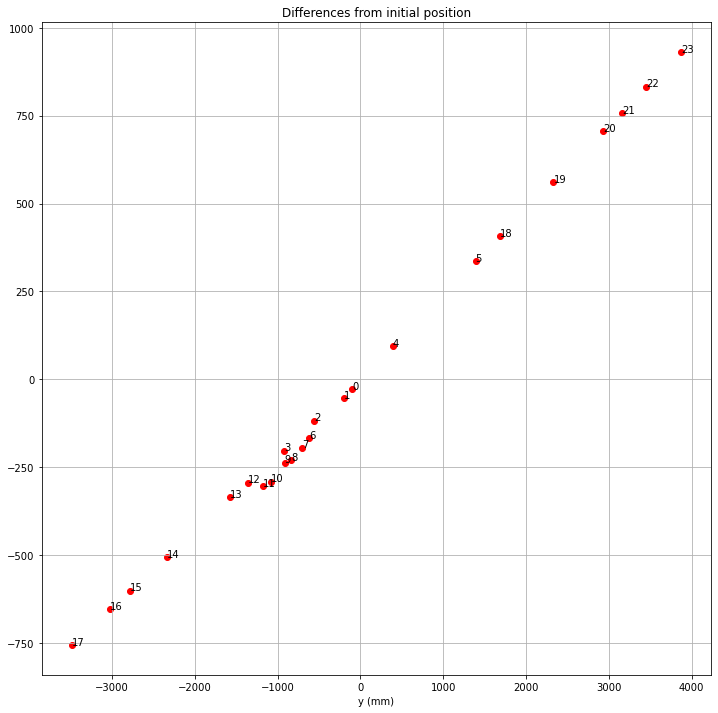

In [17]:
# Differences plot
diff = pos - pos_i[:,0:2]


fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(diff[:,0], diff[:,1], color='red')

for i in range(0,diff.shape[0]):
    ax.text(diff[i,0], diff[i,1],f"{i}")

ax.grid(True)
ax.set_title("Differences from initial position")
ax.set_xlabel('x (mm)')
ax.set_xlabel('y (mm)')
plt.savefig('differences.png')
plt.show()

In [18]:
# Residual plot
rres = radius_residual(res.x)
rres

A 0     -0.467806
A 1     -1.974860
A 2     -0.292115
A 3      3.007982
A 4     -5.642239
A 5    -11.490304
A 6      1.216441
A 7     -1.102445
A 8     -8.110386
A 9     -0.031040
A 10    -5.612800
A 11     3.394009
A 12     3.039168
A 13    -3.052214
A 14    -5.492592
A 15    -1.436389
A 16    -4.872370
A 17    -0.707413
A 18   -11.570263
A 19    -5.590825
A 20    -3.492864
A 21    -0.026544
A 22   -12.113470
A 23    -3.302661
Name: 0, dtype: float64

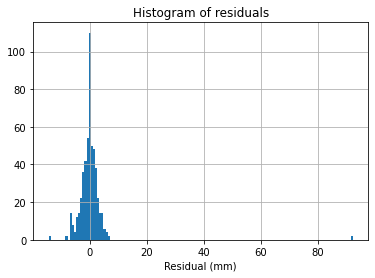

In [19]:
# ij resdual
ijres = m_ij_residual(res.x)
plt.hist(ijres, bins='fd');
plt.title("Histogram of residuals")
plt.xlabel("Residual (mm)")
plt.grid(True)
plt.savefig("residual_histogram.png")

The API expects 3D coordinates (with a z value which is zero in this case). Therefore we add a column of zeros.

In [20]:
absres = np.abs(ijres)
p95 = np.percentile(absres, 95)

print(f"95th percentile of residuals is {p95:4.2f} mm")
ijres_matrix = np.zeros_like(m_ij)
for r, i, j in zip(ijres, non_nan_indices[:,0], non_nan_indices[:,1]):
    if np.abs(r) > p95:
        print(f" res[{i},{j}] = {r:3.1f}")
    ijres_matrix[i,j] = r
    


95th percentile of residuals is 5.90 mm
 res[1,17] = -6.6
 res[1,22] = -6.7
 res[2,22] = -6.6
 res[3,22] = -6.9
 res[4,22] = -6.5
 res[5,22] = -6.6
 res[7,22] = -6.4
 res[8,22] = -5.9
 res[10,20] = 6.5
 res[13,16] = 6.2
 res[13,21] = -14.5
 res[13,22] = 92.4
 res[14,22] = -8.1
 res[16,13] = 6.2
 res[17,1] = -6.6
 res[20,10] = 6.5
 res[21,13] = -14.5
 res[22,1] = -6.7
 res[22,2] = -6.6
 res[22,3] = -6.9
 res[22,4] = -6.5
 res[22,5] = -6.6
 res[22,7] = -6.4
 res[22,8] = -5.9
 res[22,13] = 92.4
 res[22,14] = -8.1


## Output best estimates

Write some json files...

In [21]:
result = np.zeros((n_ant, 3))
result[:,:-1] = np.round(pos/1000.0, 3)
result

array([[-0.103,  0.182,  0.   ],
       [-0.201,  0.355,  0.   ],
       [-0.223, -0.312,  0.   ],
       [-0.372, -0.522,  0.   ],
       [ 0.206, -0.011,  0.   ],
       [ 0.74 , -0.039,  0.   ],
       [-0.621,  1.099,  0.   ],
       [-0.705,  1.25 ,  0.   ],
       [-0.835,  1.479,  0.   ],
       [-0.916,  1.623,  0.   ],
       [-1.078,  1.91 ,  0.   ],
       [-1.175,  2.081,  0.   ],
       [-0.546, -0.765,  0.   ],
       [-0.628, -0.88 ,  0.   ],
       [-0.938, -1.315,  0.   ],
       [-1.116, -1.565,  0.   ],
       [-1.211, -1.698,  0.   ],
       [-1.398, -1.96 ,  0.   ],
       [ 0.901, -0.047,  0.   ],
       [ 1.247, -0.065,  0.   ],
       [ 1.569, -0.082,  0.   ],
       [ 1.694, -0.089,  0.   ],
       [ 1.841, -0.097,  0.   ],
       [ 2.07 , -0.108,  0.   ]])

In [22]:
json_result = {}
json_result["antenna_positions"] = result.tolist()
print(json.dumps(json_result, indent=4, separators=(',', ': ')))

{
    "antenna_positions": [
        [
            -0.103,
            0.182,
            0.0
        ],
        [
            -0.201,
            0.355,
            0.0
        ],
        [
            -0.223,
            -0.312,
            0.0
        ],
        [
            -0.372,
            -0.522,
            0.0
        ],
        [
            0.206,
            -0.011,
            0.0
        ],
        [
            0.74,
            -0.039,
            0.0
        ],
        [
            -0.621,
            1.099,
            0.0
        ],
        [
            -0.705,
            1.25,
            0.0
        ],
        [
            -0.835,
            1.479,
            0.0
        ],
        [
            -0.916,
            1.623,
            0.0
        ],
        [
            -1.078,
            1.91,
            0.0
        ],
        [
            -1.175,
            2.081,
            0.0
        ],
        [
            -0.546,
            -0.765,
          

The position file above is in a format suitable for uploading to the telescope api. Also for using as the calibrated_antenna_positions.json file in TART/software/containers/telescope_web_api/config_data.


    tart_upload_antenna_positions --api https://tart.elec.ac.nz/rhodes --pw=xxxx --file rhodes_antenna_positions.json
